In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-5-protein-function-prediction/IA.txt
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta
/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo
/kaggle/input/t5embeds/train_ids.npy
/kaggle/input/t5embeds/test_embeds.npy
/kaggle/input/t5embeds/train_embeds.npy
/kaggle/input/t5embeds/test_ids.npy


In [2]:
from pathlib import Path
from tqdm import tqdm
#для выполнения этой задачи возьмем эмбединги
#для белков из https://www.kaggle.com/datasets/sergeifironov/t5embeds
root_emb = Path('/kaggle/input/t5embeds/')
root_cafa = Path("/kaggle/input/cafa-5-protein-function-prediction/")

In [3]:
embedings = np.load(root_emb / "train_embeds.npy")
proteins_ids = np.load(root_emb / "train_ids.npy")

In [4]:
embedings.shape

(142246, 1024)

In [5]:
train_df = pd.read_csv(root_cafa / "Train/train_terms.tsv", sep="\t")

In [6]:
train_df, train_df["term"].unique().shape, train_df["EntryID"].unique().shape

(            EntryID        term aspect
 0        A0A009IHW8  GO:0008152    BPO
 1        A0A009IHW8  GO:0034655    BPO
 2        A0A009IHW8  GO:0072523    BPO
 3        A0A009IHW8  GO:0044270    BPO
 4        A0A009IHW8  GO:0006753    BPO
 ...             ...         ...    ...
 5363858      X5L565  GO:0050649    MFO
 5363859      X5L565  GO:0016491    MFO
 5363860      X5M5N0  GO:0005515    MFO
 5363861      X5M5N0  GO:0005488    MFO
 5363862      X5M5N0  GO:0003674    MFO
 
 [5363863 rows x 3 columns],
 (31466,),
 (142246,))

In [7]:
train_tax = pd.read_csv(root_cafa / "Train/train_taxonomy.tsv", sep="\t")

In [8]:
train_tax

,EntryID,taxonomyID
0,Q8IXT2,9606
1,Q04418,559292
2,A8DYA3,7227
3,Q9UUI3,284812
4,Q57ZS4,185431
...,...,...
142241,Q5TD07,9606
142242,A8BB17,7955
142243,A0A2R8QBB1,7955
142244,P0CT72,284812


In [9]:
# возьмем 1000 самых частых term'ов, для ускорения всех процессов
unique_labels = train_df["term"].value_counts()[:1000].index

In [10]:
unique_proteins = train_df["EntryID"].unique()

In [11]:
labels = pd.DataFrame(np.zeros((len(unique_proteins), len(unique_labels) + 1)),
                      columns=np.concatenate((["ID"], unique_labels)))

In [12]:
labels["ID"] = unique_proteins

In [13]:
labels

,ID,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,...,GO:0060538,GO:0048565,GO:0016810,GO:0010498,GO:0035120,GO:0009532,GO:0009651,GO:0016607,GO:0006721,GO:0030017
0,A0A009IHW8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A0A021WW32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A0A023FFD0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A0A023GPJ3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A0A023GPK8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,X5CY81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142242,X5D6G5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142243,X5D778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142244,X5E0F1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
n_labels = len(unique_labels)
n_proteins = len(unique_proteins)
for i, label in enumerate(tqdm(unique_labels)):
    proteins = train_df[train_df["term"] == label]["EntryID"]
    labels.loc[labels["ID"].isin(proteins), label] = 1.

100%|██████████| 1000/1000 [15:23<00:00,  1.08it/s]


In [15]:
#np.save('labels_1000.npy', labels.values)

In [16]:
import torch.nn as nn
import torch
class SimpleMLP(nn.Module):
    def __init__(self, n_hidden=2048, n_input=1024, n_output=1000):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
                        nn.BatchNorm1d(n_input),
                        nn.Linear(n_input, n_hidden, bias=False),
                        nn.PReLU(),
                        nn.BatchNorm1d(n_hidden),
                        nn.Linear(n_hidden, n_hidden, bias=False),
                        nn.PReLU(),
                        nn.BatchNorm1d(n_hidden),
                        nn.Linear(n_hidden, n_hidden, bias=False),
                        nn.PReLU(),
                        nn.Linear(n_hidden, n_output, bias=False),
                        nn.PReLU(),
                        nn.Sigmoid())
    def forward(self, x):
        return self.model(x)


In [17]:
from torch.utils.data import Dataset, DataLoader

In [18]:
#labels = np.load("labels_1000.npy", allow_pickle=True)

In [19]:
names = labels.columns[1:]

In [171]:
train_df[train_df["term"].isin(names)][["term", "aspect"]].drop_duplicates()["aspect"].value_counts()

aspect
BPO    713
CCO    151
MFO    136
Name: count, dtype: int64

In [141]:
labels

,ID,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,...,GO:0060538,GO:0048565,GO:0016810,GO:0010498,GO:0035120,GO:0009532,GO:0009651,GO:0016607,GO:0006721,GO:0030017
0,A0A009IHW8,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,A0A021WW32,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,A0A023FFD0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,A0A023GPJ3,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,A0A023GPK8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142241,X5CY81,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142242,X5D6G5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142243,X5D778,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
142244,X5E0F1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
labels[names].values.sum(axis=1) / 1000

array([0.035, 0.06 , 0.024, ..., 0.004, 0.004, 0.003])

In [155]:
labels[names].values.sum(axis=0) / labels.shape[0]

array([0.6531783 , 0.64824318, 0.6417474 , 0.55282398, 0.49762383,
       0.43089437, 0.42801204, 0.4099588 , 0.40338568, 0.3898317 ,
       0.37395076, 0.36709644, 0.33735219, 0.29144581, 0.27597261,
       0.23823517, 0.21862126, 0.21405171, 0.20579841, 0.20339412,
       0.20162254, 0.19876833, 0.19238502, 0.18115096, 0.17802961,
       0.17767108, 0.17166739, 0.15314315, 0.15170198, 0.14388454,
       0.13679119, 0.13479465, 0.12995796, 0.12910029, 0.12805984,
       0.1226748 , 0.122253  , 0.12150781, 0.11835834, 0.11766939,
       0.11709995, 0.11350056, 0.11335292, 0.11034405, 0.11032999,
       0.11028781, 0.1083686 , 0.1076445 , 0.10552142, 0.10550033,
       0.10374281, 0.10259691, 0.10172518, 0.10092375, 0.09830856,
       0.09650886, 0.09518721, 0.09497631, 0.09295165, 0.09140503,
       0.09113086, 0.09061063, 0.08998496, 0.08923977, 0.08876172,
       0.0842906 , 0.08105676, 0.0805506 , 0.07897586, 0.07836424,
       0.07742221, 0.07671217, 0.07658563, 0.07600917, 0.07545

In [152]:
# в качестве весов для BCELoss'a возьмем обратное к кол-ву единиц в каждом классе
weights = 1 / (labels[names].values.sum(axis=0) / labels.shape[0])

In [20]:
from sklearn.model_selection import train_test_split
train_ids, val_ids = train_test_split(np.arange(len(proteins_ids)), random_state=42)

In [21]:
device = "cuda:0"

In [22]:
embedings = torch.from_numpy(embedings).to(device)
embedings = embedings.to(torch.float32)

In [82]:
from torchmetrics.classification import BinaryPrecision

In [69]:
precision = BinaryPrecision(multidim_average="samplewise").to(device)

In [144]:
#calc_loss = nn.CrossEntropyLoss()
calc_loss = nn.BCELoss(weight=torch.from_numpy(weights).to(device))
losses_train = []
losses_val = []
train_acc = []
val_acc = []
train_precision = []
val_precision = []

batch_size = 8096
n_epochs = 300

model = SimpleMLP().to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

for epoch in tqdm(range(n_epochs)):
    model.train()
    losses_epoch = []
    batch_ids = np.random.choice(train_ids, size=batch_size, replace=False)
    proteins = proteins_ids[batch_ids]

    opt.zero_grad()
    x_train = embedings[batch_ids]
    y_train = torch.from_numpy(labels[labels["ID"].isin(proteins)][names].values)
    y_train = y_train.to(device).to(torch.float32)
    y_pred = model(x_train)

    loss = calc_loss(y_pred, y_train)
    loss.backward()

    opt.step()
    losses_train.append(loss.item())
    train_acc.append((((y_pred > 0.5) == y_train).sum(dim=0)/y_train.shape[0]).mean().item())
    train_precision.append(precision((y_pred > 0.5) + 0.0, y_train).mean().item())

    model.eval()
    
    batch_ids = np.random.choice(val_ids, size=batch_size, replace=False)
    #batch_ids = val_ids
    x_val = embedings[batch_ids]
    proteins = proteins_ids[batch_ids]
    y_val = torch.from_numpy(labels[labels["ID"].isin(proteins)][names].values)
    y_val = y_val.to(device).to(torch.float32)
    with torch.no_grad():
        y_pred = model(x_val)
        loss = calc_loss(y_pred, y_val)
    losses_val.append(loss.item())
    val_acc.append((((y_pred > 0.5) == y_val).sum(dim=0)/y_val.shape[0]).mean().item())
    val_precision.append(precision((y_pred > 0.5) + 0.0, y_val).mean().item())
    

100%|██████████| 300/300 [02:48<00:00,  1.78it/s]


In [28]:
import matplotlib.pyplot as plt

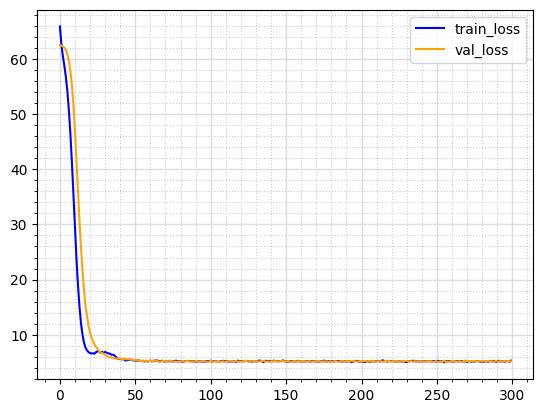

In [145]:
plt.plot(losses_train, color="blue", label="train_loss")
plt.plot(losses_val, color="orange", label="val_loss")

plt.legend(loc='best')

plt.grid(which='major', color='#DDDDDD', linewidth=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', linewidth=0.8)
plt.minorticks_on()

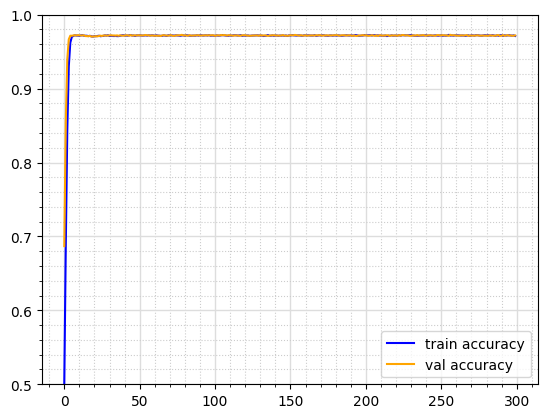

In [146]:
plt.plot(train_acc, color="blue", label="train accuracy")
plt.plot(val_acc, color="orange", label="val accuracy")
plt.ylim(0.5, 1)
plt.legend(loc='best')

plt.grid(which='major', color='#DDDDDD', linewidth=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', linewidth=0.8)
plt.minorticks_on()

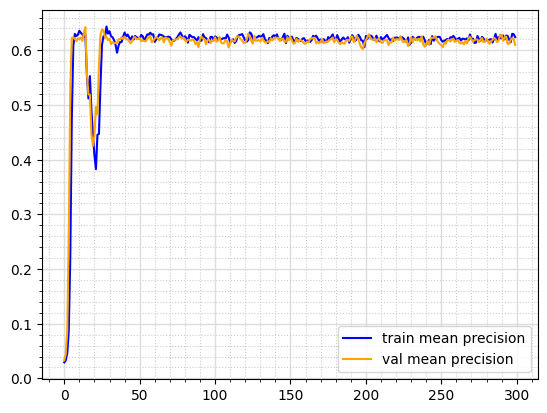

In [147]:
plt.plot(train_precision, color="blue", label="train mean precision")
plt.plot(val_precision, color="orange", label="val mean precision")

plt.legend(loc='best')

plt.grid(which='major', color='#DDDDDD', linewidth=1)
plt.grid(which='minor', color='#CCCCCC', linestyle=':', linewidth=0.8)
plt.minorticks_on()